In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from ipywidgets import widgets
from io import BytesIO

In [ ]:
!git clone https://github.com/GitKentC/dataset.git

Cloning into 'dataset'...
remote: Enumerating objects: 15514, done.
remote: Total 15514 (delta 0), reused 0 (delta 0), pack-reused 15514 (from 1)
Receiving objects: 100% (15514/15514), 236.08 MiB | 16.71 MiB/s, done.
Resolving deltas: 100% (21/21), done.
Updating files: 100% (30916/30916), done.


In [ ]:
""" DATASET VARIABLES """
DATASET_NAME = 'garbage_classification'
DATASET_DIR = f'/content/dataset/dupe_cleaned/{DATASET_NAME}'
TRAIN_DIR = f'/content/dataset/split/{DATASET_NAME}/train'
VALIDATION_DIR = f'/content/dataset/split/{DATASET_NAME}/validation'
TEST_DIR = f'/content/dataset/split/{DATASET_NAME}/test'

In [ ]:
""" Change this to match pre-trained models input; for consistency """
IMAGE_SIZE:tuple[int,int] = (256, 256) # try testing this

BATCH_SIZE:int = 32                    # try testing this
LABEL_MODE:str = 'categorical'
COLOR_MODE:str = 'rgb'                 # accepts 'grayscale', 'rgb', and 'rgba' only
VALIDATION_SPLIT:float = 0.2           # try testing this
SEED:int               = 42

def load_datasets_cleaned():
    """ Function to load from cleaned dataset; customizable """
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        DATASET_DIR,
        subset     = 'training',
        image_size = IMAGE_SIZE,
        batch_size = BATCH_SIZE,
        label_mode = LABEL_MODE,
        color_mode = COLOR_MODE,
        validation_split = VALIDATION_SPLIT,
        seed             = SEED,
        pad_to_aspect_ratio=True,
        )

    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        DATASET_DIR,
        subset     = 'training',
        image_size = IMAGE_SIZE,
        batch_size = BATCH_SIZE,
        label_mode = LABEL_MODE,
        color_mode = COLOR_MODE,
        validation_split = VALIDATION_SPLIT,
        seed             = SEED,
        pad_to_aspect_ratio=True,
        )

    return train_dataset, validation_dataset

def load_datasets_split():
    """ Function to load from cleaned, splitted dataset  """
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR,
        image_size = IMAGE_SIZE,
        batch_size = BATCH_SIZE,
        label_mode = LABEL_MODE,
        color_mode = COLOR_MODE,
        pad_to_aspect_ratio=True,
    )

    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        VALIDATION_DIR,
        image_size = IMAGE_SIZE,
        batch_size = BATCH_SIZE,
        label_mode = LABEL_MODE,
        color_mode = COLOR_MODE,
        pad_to_aspect_ratio=True,
    )

    test_dataset = tf.keras.utils.image_dataset_from_directory(
        TEST_DIR,
        image_size = IMAGE_SIZE,
        batch_size = BATCH_SIZE,
        label_mode = LABEL_MODE,
        color_mode = COLOR_MODE,
        pad_to_aspect_ratio=True,
    )

    return train_dataset, validation_dataset, test_dataset

In [ ]:
""" Create datasets """
#train_ds, val_ds = load_datasets_cleaned()
train_ds, val_ds, test_ds = load_datasets_split()

Found 10815 files belonging to 12 classes.
Found 3087 files belonging to 12 classes.
Found 1556 files belonging to 12 classes.


In [ ]:
""" Preprocess the data  """
def preprocess(image, label):
    """ Read the docs in https://github.com/keras-team/keras/tree/master/keras/src/applications for more info """
    # CenterCrop after resizing the smallest
    image = tf.keras.layers.CenterCrop(224,224)(image)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return image, label

train_ds_prep = train_ds.map(preprocess)
val_ds_prep = val_ds.map(preprocess)
test_ds_prep = test_ds.map(preprocess)

In [ ]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_ds_final = (train_ds_prep
                  .cache()
                  .shuffle(SHUFFLE_BUFFER_SIZE)
                  .prefetch(PREFETCH_BUFFER_SIZE)
                  )

val_ds_final = (val_ds_prep
                .cache()
                .prefetch(PREFETCH_BUFFER_SIZE)
                )

test_ds_final = (test_ds_prep
                .cache()
                .prefetch(PREFETCH_BUFFER_SIZE)
                )

In [ ]:
def create_pre_trained_model():
    pre_trained_model = tf.keras.applications.ResNet50(
        include_top=False,
        input_shape=(224,224,3),
        weights="imagenet"
    )

    for layer in pre_trained_model.layers:
        layer.trainable = False

    return pre_trained_model

pre_trained_model = create_pre_trained_model()
pre_trained_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
last_output = pre_trained_model.output

print(last_output.shape)

(None, 7, 7, 2048)


In [ ]:
def create_model(pre_trained_model, last_output):

    x = tf.keras.layers.GlobalAveragePooling2D()(last_output)
    x = tf.keras.layers.Dense(1028, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(12, activation='softmax')(x)

    model = tf.keras.Model(inputs=pre_trained_model.input, outputs=x)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
model = create_model(pre_trained_model, last_output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,706,432 (98.06 MB)

 Trainable params: 2,118,720 (8.08 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitors the validation loss
    min_delta=0.001,          # Minimum change to qualify as an improvement
    patience=10,              # Number of epochs to wait for improvement
    verbose=1,                # Verbosity mode
    mode='min',               # Stop when the monitored quantity has stopped decreasing
    restore_best_weights=True # Restore model weights from the epoch with the best value
)

In [ ]:
history = model.fit(train_ds_final,
                    validation_data=val_ds_final,
                    epochs=30,
                    verbose=1,
                    callbacks = [early_stopping],)

Epoch 1/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 103s 165ms/step - accuracy: 0.8232 - loss: 0.6507 - val_accuracy: 0.9446 - val_loss: 0.1742
Epoch 2/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 35s 103ms/step - accuracy: 0.9356 - loss: 0.1953 - val_accuracy: 0.9485 - val_loss: 0.1507
Epoch 3/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 36s 107ms/step - accuracy: 0.9449 - loss: 0.1560 - val_accuracy: 0.9495 - val_loss: 0.1580
Epoch 4/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 44s 115ms/step - accuracy: 0.9650 - loss: 0.1130 - val_accuracy: 0.9482 - val_loss: 0.1674
Epoch 5/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 38s 107ms/step - accuracy: 0.9662 - loss: 0.1068 - val_accuracy: 0.9618 - val_loss: 0.1348
Epoch 6/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 36s 107ms/step - accuracy: 0.9705 - loss: 0.0920 - val_accuracy: 0.9605 - val_loss: 0.1525
Epoch 7/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 38s 114ms/step - accuracy: 0.9728 - loss: 0.0856 - val_accuracy: 0.9585 - val_loss: 0.1574
Epoch 8/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 39s 108ms/step - accuracy: 0.9774 - loss: 

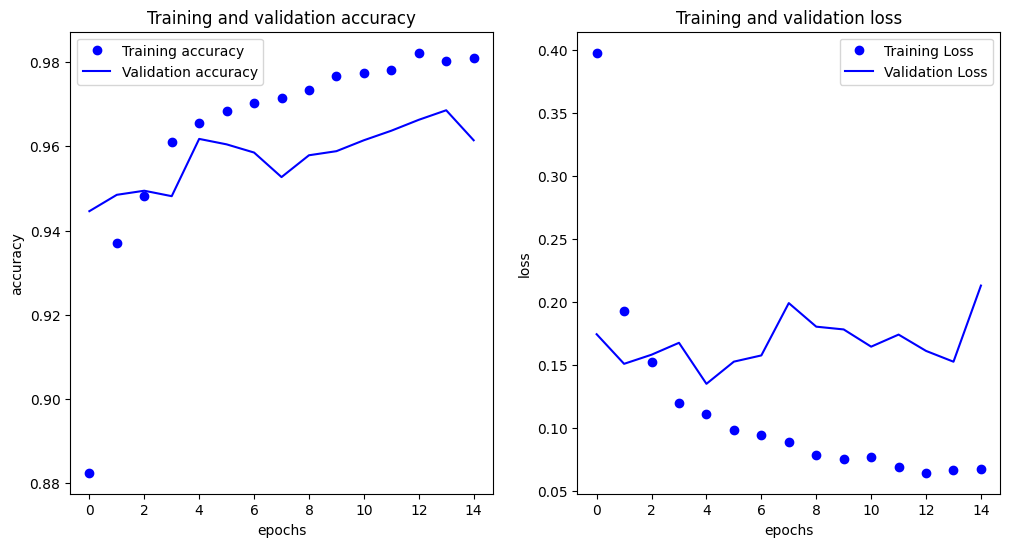

In [ ]:
def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()

    plt.show()

plot_loss_acc(history)

In [ ]:
loss, accuracy = model.evaluate(test_ds_final, verbose=1)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 223ms/step - accuracy: 0.9461 - loss: 0.2009
Test Loss: 0.1633906364440918
Test Accuracy: 0.955012857913971


In [ ]:
model_name = "resnet50_finetune_trial1.h5"
tf.keras.models.save_model(model, model_name)